Stock Price Data - First 10 rows:
            timestamp       price  volume
0 2025-06-22 00:00:00  100.000000    8889
1 2025-06-22 00:00:05  100.007558    6238
2 2025-06-22 00:00:10  100.005455    2817
3 2025-06-22 00:00:15  100.015311    8570
4 2025-06-22 00:00:20  100.038490    6103
5 2025-06-22 00:00:25  100.034927    1617
6 2025-06-22 00:00:30  100.031364    9509
7 2025-06-22 00:00:35  100.055402    7285
8 2025-06-22 00:00:40  100.067085    1456
9 2025-06-22 00:00:45  100.059939    1500

Stock Price Data - Last 10 rows:
                timestamp       price  volume
17270 2025-06-22 23:59:10  101.061615    7993
17271 2025-06-22 23:59:15  101.043022    8518
17272 2025-06-22 23:59:20  101.047677    8659
17273 2025-06-22 23:59:25  101.051619    1407
17274 2025-06-22 23:59:30  101.060595    2531
17275 2025-06-22 23:59:35  101.058627    1623
17276 2025-06-22 23:59:40  101.046921    3766
17277 2025-06-22 23:59:45  101.057015    5647
17278 2025-06-22 23:59:50  101.036825    3827
17279 2025

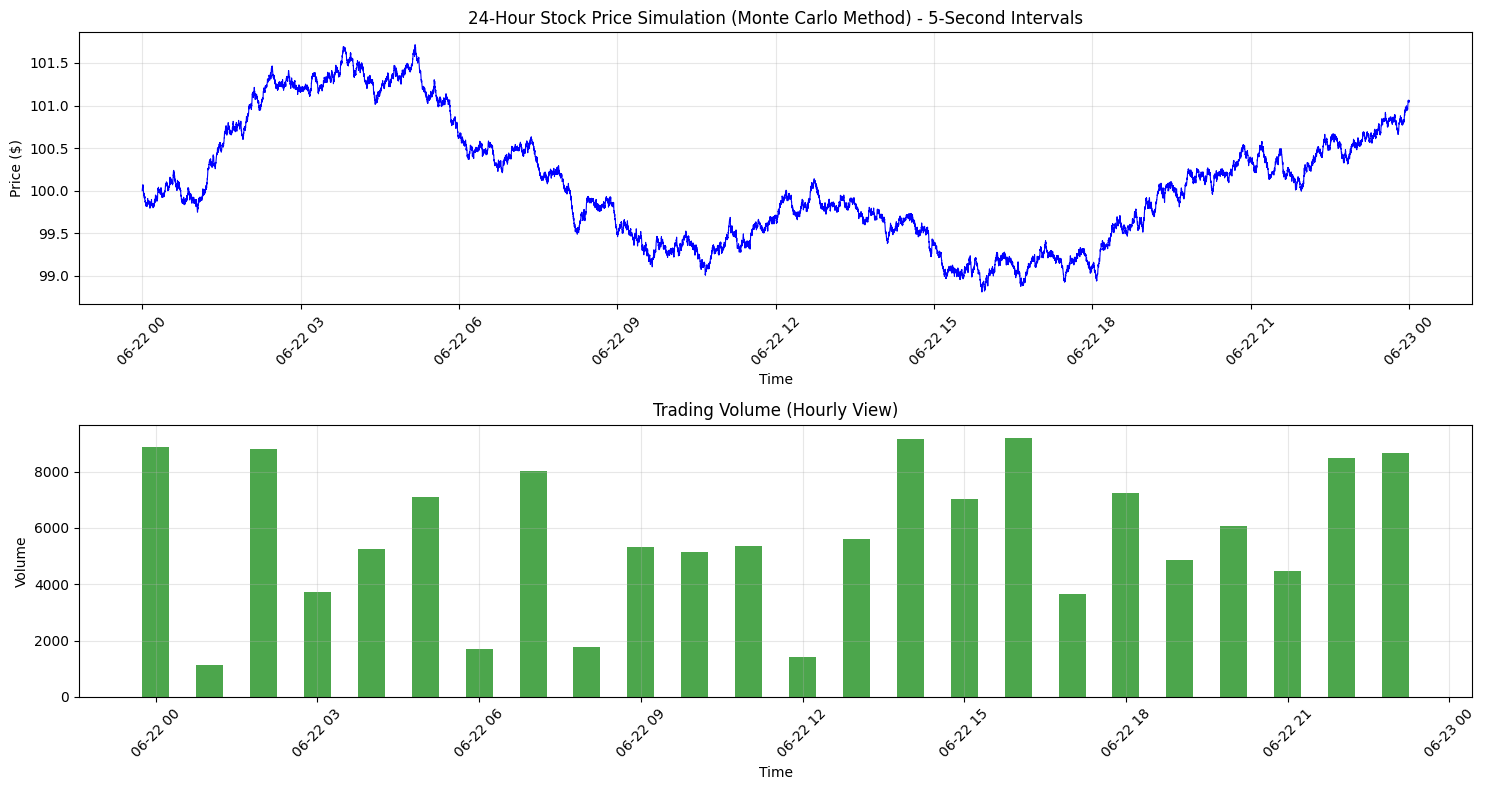


Data saved to 'stock_price_data_24h.csv'


,timestamp,price,volume
0,2025-06-22 00:00:00,100.000000,8889
1,2025-06-22 00:00:05,100.007558,6238
2,2025-06-22 00:00:10,100.005455,2817
3,2025-06-22 00:00:15,100.015311,8570
4,2025-06-22 00:00:20,100.038490,6103
...,...,...,...
17275,2025-06-22 23:59:35,101.058627,1623
17276,2025-06-22 23:59:40,101.046921,3766
17277,2025-06-22 23:59:45,101.057015,5647
17278,2025-06-22 23:59:50,101.036825,3827


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Monte Carlo Stock Price Simulation for 24 hours (17280 five-second intervals)
def generate_stock_price_data():
    """
    Generate 5-second stock price data for 24 hours using Monte Carlo method
    """
    # Parameters
    initial_price = 100.0  # Starting stock price
    drift = 0.0001  # Daily drift (small for 5-second intervals)
    volatility = 0.02  # Daily volatility
    time_step = 1 / (24 * 60 * 12)  # 5 seconds in terms of days (12 five-second intervals per minute)
    num_steps = 24 * 60 * 12  # 17280 five-second intervals in 24 hours
    
    # Generate time series
    start_time = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
    timestamps = [start_time + timedelta(seconds=i*5) for i in range(num_steps)]
    
    # Monte Carlo simulation using Geometric Brownian Motion
    prices = [initial_price]
    
    for i in range(1, num_steps):
        # Random shock (normal distribution)
        random_shock = np.random.normal(0, 1)
        
        # Calculate price change using GBM formula
        price_change = drift * time_step + volatility * np.sqrt(time_step) * random_shock
        
        # Calculate new price
        new_price = prices[-1] * np.exp(price_change)
        prices.append(new_price)
    
    # Create DataFrame
    stock_data = pd.DataFrame({
        'timestamp': timestamps,
        'price': prices,
        'volume': np.random.randint(1000, 10000, num_steps)  # Random volume data
    })
    
    return stock_data

# Generate the data
np.random.seed(42)  # For reproducible results
stock_df = generate_stock_price_data()

# Display first and last few rows
print("Stock Price Data - First 10 rows:")
print(stock_df.head(10))
print("\nStock Price Data - Last 10 rows:")
print(stock_df.tail(10))

# Basic statistics
print(f"\nData Summary:")
print(f"Total data points: {len(stock_df)}")
print(f"Starting price: ${stock_df['price'].iloc[0]:.2f}")
print(f"Ending price: ${stock_df['price'].iloc[-1]:.2f}")
print(f"Min price: ${stock_df['price'].min():.2f}")
print(f"Max price: ${stock_df['price'].max():.2f}")
print(f"Price change: ${stock_df['price'].iloc[-1] - stock_df['price'].iloc[0]:.2f}")
print(f"Percentage change: {((stock_df['price'].iloc[-1] / stock_df['price'].iloc[0]) - 1) * 100:.2f}%")

# Plot the stock price over 24 hours
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(stock_df['timestamp'], stock_df['price'], linewidth=0.8, color='blue')
plt.title('24-Hour Stock Price Simulation (Monte Carlo Method) - 5-Second Intervals')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot volume
plt.subplot(2, 1, 2)
plt.bar(stock_df['timestamp'][::720], stock_df['volume'][::720], width=timedelta(minutes=30), alpha=0.7, color='green')
plt.title('Trading Volume (Hourly View)')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Save to CSV for future use
stock_df.to_csv('stock_price_data_24h.csv', index=False)
print(f"\nData saved to 'stock_price_data_24h.csv'")

stock_df

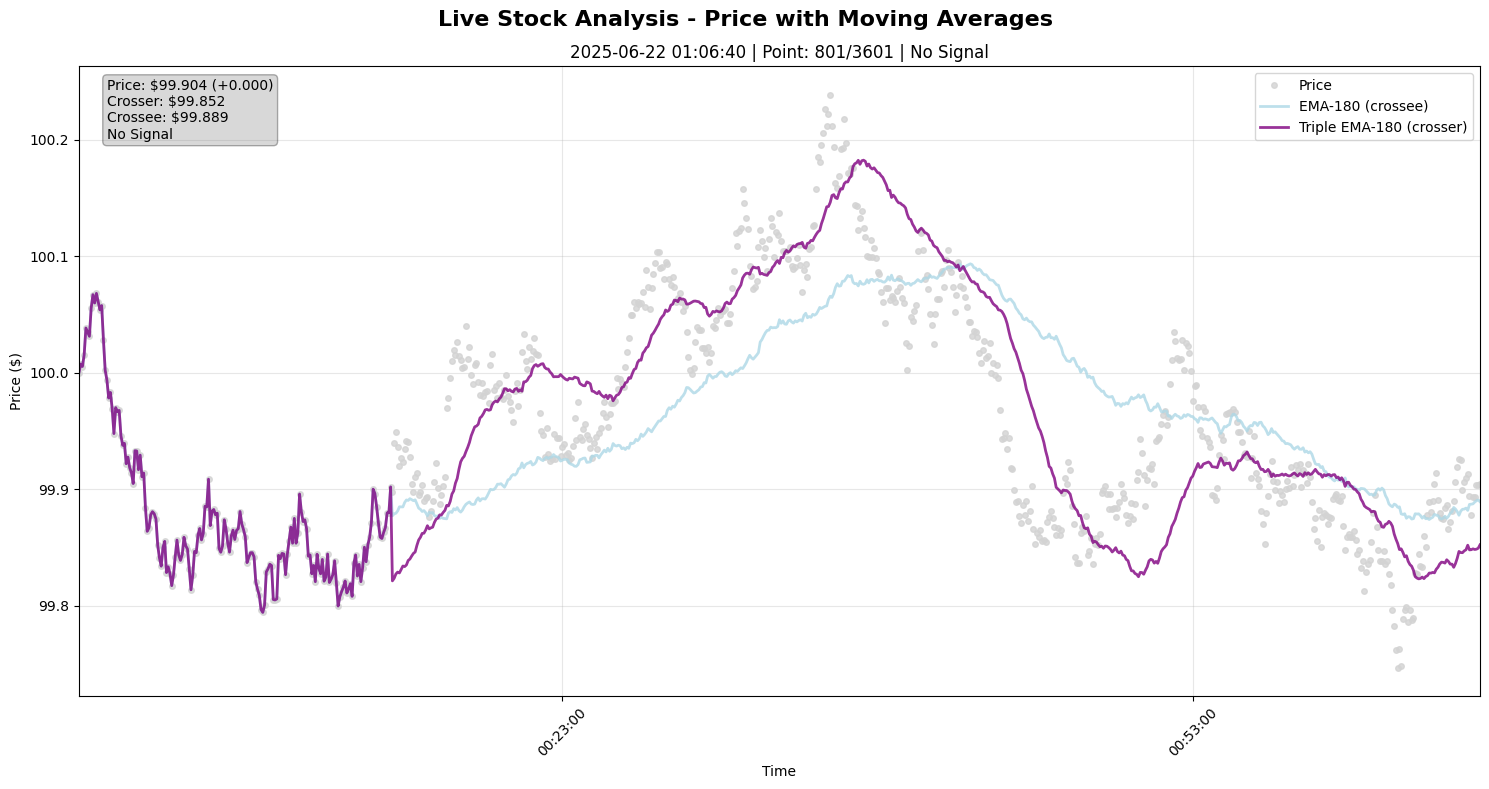

In [ ]:
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

def calculate_ema(values, period):
    """Calculate Exponential Moving Average"""
    if len(values) == 0:
        return None
    if len(values) == 1:
        return values[0]
    
    alpha = 2.0 / (period + 1)
    ema = [values[0]]  # First EMA is the first value
    
    for i in range(1, len(values)):
        ema_value = alpha * values[i] + (1 - alpha) * ema[-1]
        ema.append(ema_value)
    
    return ema[-1]  # Return the latest EMA value

def calculate_triple_ema(values, period):
    """Calculate Triple Exponential Moving Average (TEMA)"""
    if len(values) < period:
        return None
    
    # Calculate EMA1
    ema1_values = []
    for i in range(len(values)):
        current_values = values[:i+1]
        ema1 = calculate_ema(current_values, period)
        ema1_values.append(ema1)
    
    # Calculate EMA2 (EMA of EMA1)
    ema2_values = []
    for i in range(len(ema1_values)):
        current_ema1 = ema1_values[:i+1]
        ema2 = calculate_ema(current_ema1, period)
        ema2_values.append(ema2)
    
    # Calculate EMA3 (EMA of EMA2)
    ema3_values = []
    for i in range(len(ema2_values)):
        current_ema2 = ema2_values[:i+1]
        ema3 = calculate_ema(current_ema2, period)
        ema3_values.append(ema3)
    
    # TEMA formula: 3*EMA1 - 3*EMA2 + EMA3
    tema = 3 * ema1_values[-1] - 3 * ema2_values[-1] + ema3_values[-1]
    return tema

def process_moving_averages_data():
    """
    Process stock data row by row and calculate moving averages
    Returns the processed data for display
    """
    print("Processing Moving Averages Data...")
    print("Calculating Triple EMA (crosser) and EMA (crossee) with 180-data-point periods (15 minutes)")
    print("-" * 70)
    
    # Parameters
    ema_period = 180  # 180 five-second intervals = 15 minutes
    
    # Initialize data containers
    processed_data = {
        'timestamps': [],
        'prices': [],
        'crosser_values': [],  # Triple EMA
        'crossee_values': [],  # EMA
        'signals': [],
        'price_changes': []
    }
    price_history = []  # For EMA calculations
    
    print("Processing data...")
    
    # Process each row from stock_df
    for i in range(len(stock_df)):
        # Get current row's data
        current_row = stock_df.iloc[i]
        current_price = current_row['price']
        current_timestamp = current_row['timestamp']
        
        # Add to data containers
        processed_data['timestamps'].append(current_timestamp)
        processed_data['prices'].append(current_price)
        price_history.append(current_price)
        
        # Calculate moving averages
        if len(price_history) >= ema_period:
            # Calculate EMA (crossee) - using last 180 values (15 minutes)
            recent_prices = price_history[-ema_period:]
            crossee = calculate_ema(recent_prices, ema_period)
            processed_data['crossee_values'].append(crossee)
            
            # Calculate Triple EMA (crosser) - using last 180 values (15 minutes)
            crosser = calculate_triple_ema(recent_prices, ema_period)
            processed_data['crosser_values'].append(crosser if crosser is not None else crossee)
        else:
            # Not enough data yet, use current price
            processed_data['crossee_values'].append(current_price)
            processed_data['crosser_values'].append(current_price)
        
        # Calculate change for display
        if i > 0:
            change = current_price - stock_df.iloc[i-1]['price']
            change_str = f"{change:+.3f}"
        else:
            change_str = "0.000"
        processed_data['price_changes'].append(change_str)
        
        # Determine crossover signal
        if len(processed_data['crosser_values']) > 1 and len(processed_data['crossee_values']) > 1:
            current_crosser = processed_data['crosser_values'][-1]
            current_crossee = processed_data['crossee_values'][-1]
            prev_crosser = processed_data['crosser_values'][-2]
            prev_crossee = processed_data['crossee_values'][-2]
            
            if current_crosser > current_crossee and prev_crosser <= prev_crossee:
                signal = "🟢 BULLISH CROSS"
            elif current_crosser < current_crossee and prev_crosser >= prev_crossee:
                signal = "🔴 BEARISH CROSS"
            else:
                signal = "No Signal"
        else:
            signal = "Calculating..."
        processed_data['signals'].append(signal)
        
        # Optional: Break early for demo (remove for full dataset)
        if i >= 3600:  # Stop after 3600 rows (5 hours of 5-second data) for demo
            break
    
    print(f"✅ Data processing completed! Processed {len(processed_data['prices'])} data points.")
    return processed_data

def display_live_chart(processed_data):
    """
    Display live chart using the processed moving averages data
    """
    print("Starting Live Chart Display...")
    print("-" * 70)
    
    # Parameters
    ema_period = 180  # 180 five-second intervals = 15 minutes
    
    # Enable interactive plotting
    plt.ion()
    
    # Create figure and subplots
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    fig.suptitle('Live Stock Analysis - Price with Moving Averages', fontsize=16, fontweight='bold')
    
    # Initialize live display containers
    live_timestamps = []
    live_prices = []
    live_crosser_values = []
    live_crossee_values = []
    
    print("Displaying live chart...")
    
    # Display each data point progressively
    for i in range(len(processed_data['prices'])):
        # Add current data point to live display
        live_timestamps.append(processed_data['timestamps'][i])
        live_prices.append(processed_data['prices'][i])
        live_crosser_values.append(processed_data['crosser_values'][i])
        live_crossee_values.append(processed_data['crossee_values'][i])
        
        # Get current values
        current_price = processed_data['prices'][i]
        current_timestamp = processed_data['timestamps'][i]
        current_crosser = processed_data['crosser_values'][i]
        current_crossee = processed_data['crossee_values'][i]
        change_str = processed_data['price_changes'][i]
        signal = processed_data['signals'][i]
        
        # Clear previous plot
        ax.clear()
        
        # Plot price line
        ax.plot(live_timestamps, live_prices, color='lightgray', marker='o', markersize=4, linestyle='', label='Price', alpha=0.8)
        
        # Plot moving averages (only if we have enough data)
        if len(live_timestamps) >= ema_period:
            # Plot EMA (crossee)
            ax.plot(live_timestamps, live_crossee_values, color='lightblue', linewidth=2, 
                   label=f'EMA-{ema_period} (crossee)', alpha=0.8)
            
            # Plot Triple EMA (crosser)
            ax.plot(live_timestamps, live_crosser_values, color='purple', linewidth=2, 
                   label=f'Triple EMA-{ema_period} (crosser)', alpha=0.8)
        
        # Determine signal color for annotation
        if "BULLISH" in signal:
            signal_color = "green"
        elif "BEARISH" in signal:
            signal_color = "red"
        else:
            signal_color = "gray"
        
        # Add current values annotation
        textstr = f'Price: ${current_price:.3f} ({change_str})\nCrosser: ${current_crosser:.3f}\nCrossee: ${current_crossee:.3f}\n{signal}'
        
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle='round', 
               facecolor=signal_color, alpha=0.3))
        
        # Format x-axis for timestamps
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
        
        # Set title with current info
        ax.set_title(f'{current_timestamp.strftime("%Y-%m-%d %H:%M:%S")} | Point: {i+1}/{len(processed_data["prices"])} | {signal}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Price ($)')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')
        
        # Set y-axis limits to focus on price range
        if len(live_prices) > 0:
            all_values = live_prices + live_crosser_values + live_crossee_values
            y_min = min(all_values)
            y_max = max(all_values)
            y_range = y_max - y_min
            margin = y_range * 0.05 if y_range > 0 else 1
            ax.set_ylim(y_min - margin, y_max + margin)
        
        # Set x-axis to show all timestamps
        if len(live_timestamps) > 1:
            ax.set_xlim(live_timestamps[0], live_timestamps[-1])
        
        # Rotate x-axis labels
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        
        # Adjust layout and display
        plt.tight_layout()
        
        # Clear output and display new plot
        clear_output(wait=True)
        display(fig)
        
        # Wait 0.1 seconds before displaying next point
        time.sleep(0.1)
    
    # Turn off interactive mode and clean up
    plt.ioff()
    plt.close(fig)
    
    print("\n" + "="*70)
    print("Live chart display completed!")
    print(f"Displayed {len(processed_data['prices'])} data points")
    
    if len(processed_data['prices']) > 0:
        final_price = processed_data['prices'][-1]
        final_crosser = processed_data['crosser_values'][-1]
        final_crossee = processed_data['crossee_values'][-1]
        final_signal = processed_data['signals'][-1]
        
        print(f"Final Price: ${final_price:.3f}")
        print(f"Final Crosser (Triple EMA): ${final_crosser:.3f}")
        print(f"Final Crossee (EMA): ${final_crossee:.3f}")
        print(f"Time span: {processed_data['timestamps'][0].strftime('%H:%M:%S')} to {processed_data['timestamps'][-1].strftime('%H:%M:%S')}")
        
        # Final signal
        if final_crosser > final_crossee:
            print("📈 Current Signal: BULLISH (Crosser above Crossee)")
        else:
            print("📉 Current Signal: BEARISH (Crosser below Crossee)")

def process_stock_data_with_moving_averages():
    """
    Main function that calls processing and display separately
    """
    # Step 1: Process the moving averages data
    processed_data = process_moving_averages_data()
    
    # Step 2: Display the live chart
    display_live_chart(processed_data)

# Run the analysis
process_stock_data_with_moving_averages()